In [1]:
#Inspired by and adapted to my needs from https://github.com/ageron
#Based on Mnih 2013, playing atari with deep reinforcement learning

In [6]:
%reset -f
import tensorflow as tf
from importlib import reload
sess = tf.InteractiveSession()
import os
import random
from params import * 
import world 
from copy import copy
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
%matplotlib inline
from network import *

In [21]:
world = reload(world)
my_world = world.world(game_mode='abs_length',goal_reward = 100)

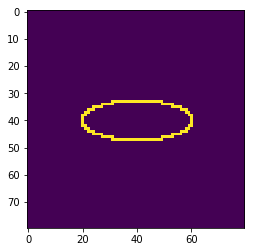

In [8]:
plt.imshow(my_world.get_frame()[:,:,0])


In [9]:
#New way of changing the axes: Change them by a certain percentage. 
#This is because the goal is to make the network indifferent to the scale of the ellipse and
#only learn to recognize the ratio that the axes have. However, if the benefit that an action has depends on the 
#scale, then learning to ignore the scale might prove difficult.

# Maybe need to change to different world, learning scale invariance might be an unnecessary complicated task
# requiring a network with too many parameters.

def increase_height():
    #change in percent
    my_world.change_height(.1)
def decrease_height():
    #change in percent
    my_world.change_height(-.1)
def increase_width():
    #change in percent
    my_world.change_width(.1)
def decrease_width():
    #change in percent
    my_world.change_width(-.1)
actions = [increase_height,decrease_height,increase_width,decrease_width]

num_actions = len(actions)
num_targets = 4

### How does the model architecture look like?

- We have the input with dimensions [FRAME_DIM,FRAME_DIM,1] (in the DQN of Mnih, the 4 last images are taken. However, our task is much simpler and does not require to learn any correlations between the images, so 1 is sufficient as the last dimension (taking just 1 image.)
- Moreover, in our case, it is sufficient to take $\Phi$ to be the identity function, since we do not need preprocessing for image cropping etc.


- First hidden layer: 16 filters of size 8x8 with stride 4. acitvation : relu
- Second hidden layer: 32 filters of size 4x4 with stride 2, again relu
- Final hidden 128 relus, fully connected.
- output layer: fully connected, one output for each action. 

In [10]:
dqn_args   = {"n_out_h1" : 16, "kernel_size_h1":(8,8), "strides_h1" : 4, "padding" : "SAME", \
              "actvt_fct" : tf.nn.relu, "n_out_h2" : 32, "kernel_size_h2":(4,4), "strides_h2" : 2, \
              "n_out_h3" : 128,"initializer" : tf.contrib.layers.variance_scaling_initializer() }

learning_rate  = 10**(-3)

# start training after memory is somewhat filled.
training_start = 500  
# gamma discount factor for future rewards. 
discount_rate  = 1
batch_size     = 32 

#Precision at what the goal state will be accepted. For more info look at my_world.game_over()
precision = 1


over = True

# We will keep track of the max Q-Value over time and compute the mean per game
prediction_loss = np.infty
game_length = 0
finished   = -1



num_total_updates = 250000
verbose = True

#Time interval after which the target network gets updated by the online learning network
learn_period = 20


game_length_over_t = []

time = []
t = 0 

#Epsilon greedy policy: initially fully exploratory then decaying epsilon
eps_min = 0.25
eps_max = 1.0 
exploratory_steps = num_total_updates//6
eps_decay_steps = num_total_updates-exploratory_steps

In [11]:


#x is our current state, i.e. just the current image.
#Same for learning network as for predicting network, therefore defined outside the scope so that it can be shared.

learner_out  , learner_vars   = network("learner"  ,**dqn_args,num_actions=num_actions,num_targets=num_targets)
predictor_out, predictor_vars = network("predictor",**dqn_args,num_actions=num_actions,num_targets=num_targets)




In [12]:
#clever way in tensorflow of updating the predictor network!
#Since all operations are just stored as nodes in the graph, the reassignment operations can be put into 
#a single group of operations. Whenever this group is then called during a session, the assignment node
# gets activated -> Transfer of current learning parameter values into the predicting network.
update_operations = [predictor_var.assign(learner_vars[var_name])
                    for var_name, predictor_var in predictor_vars.items()]

update_predictor = tf.group(*update_operations)


### Training step of the network

In [13]:
#Define all the variables that will be used for the training, e.g. actions taken, target, q_value and so on.

with tf.variable_scope("training",reuse=tf.AUTO_REUSE):
    
    #Placeholder for batch of actions during training.
    act_idx = tf.placeholder(tf.int32, shape=[None])
    #Placeholder for estimated discounted future reward achieved in a step.
    y = tf.placeholder(tf.float32, shape=[None, 1])
    
    # The q_value of the online learning network for a certain step.
    q_value_per_target = [tf.reduce_sum(output * tf.one_hot(act_idx, num_actions), axis=1, keep_dims=True)\
                         for output in learner_out]
    
    ### As in the paper by Mnih, loss is squared difference between target and estimate. 
    loss_per_target = [tf.squared_difference(y,q_value,"loss") for q_value in q_value_per_target]
    
    #Keeping track of how many batches the network has seen for training.
    global_step = tf.Variable(0, trainable=False, name='global_step')
    # Optimizer used by Mnih
    optimizer = tf.train.RMSPropOptimizer(learning_rate)
    training_step_per_target = [optimizer.minimize(loss, global_step=global_step) for loss in loss_per_target]

In [14]:
#Memory for replay
max_memory = 5000
#Using deque so that max_length is automatically maintained when pushing new data into the replay buffer.
memory = deque([],maxlen=max_memory)


In [15]:
def sample_memories(batch_size):
    
    '''
    Sample memories from the replay buffer. Returns a batch of batch_size that includes the 
    remembered state-action-reward-next_state-game_over tuple.
    '''
    
    memo_batch  = np.array(random.sample(memory,batch_size))
    
    mem_states       = np.stack(np.array(memo_batch[:,0]))
    mem_actions      = np.stack(np.array(memo_batch[:,1]))
    mem_rewards      = np.stack(np.array(memo_batch[:,2]))
    mem_nxt_state    = np.stack(np.array(memo_batch[:,3]))
    mem_final_state  = np.stack(np.array(memo_batch[:,4]))

    
    return (mem_states, mem_actions, mem_rewards.reshape(-1, 1), mem_nxt_state, mem_final_state.reshape(-1, 1))


def epsilon_greedy(q_values, num_updates):
    '''
    Custom epsilon greedy policy. Learn completely random in the first "exploratory_steps" number of steps to
    explore the state space more or less equally. Then decay to minimal epsilon to become more and more greedy.
    '''
    
    #First completely random, then decaying linearly from eps_max to eps_min
    epsilon = 1 if num_updates< exploratory_steps else  \
                max(eps_min, eps_max - (eps_max-eps_min) * (num_updates-exploratory_steps)/eps_decay_steps)
        
    if np.random.rand() < epsilon:
        # explore
        return np.random.randint(num_actions) 
    else:
        # exploit
        return np.argmax(q_values) 



In [16]:
#!rm -r learnt_var-simple_reward_structure/

In [17]:
save_path = "multi_target/"
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [18]:
targets = [{"vaxis" : vaxis, "haxis" : haxis} for vaxis,haxis in \
           zip(np.linspace(5,20,num_targets),np.linspace(5,20,num_targets))]

In [ ]:
start_at = 0
current_target = 0
with tf.Session() as sess:
    
    if os.path.isfile(save_path+".index"):
        saver.restore(sess, save_path)
        start_at = global_step.eval()
        #sess.run(tf.assign(global_step,0))
        print("Retrieving saved parameters")
    else:
        init.run()
        
    #start with online being the same as predictor network
    update_predictor.run()
    
    print("Starting learning process - Filling memory.",end="")
    
    while True:
        t +=1
        num_updates = global_step.eval()
        if num_updates-start_at >= num_total_updates:
            saver.save(sess, save_path)
            break
            
        #Reset world if goal is reached  
        if over:            
            finished +=1
            my_world.restart()
            state = my_world.get_frame()


        #Perform actions according to online network and our custom epsilon greedy policy.
        q_values = learner_out[current_target].eval(feed_dict={x: [state]})
        action_idx = epsilon_greedy(q_values, num_updates-start_at)
        #Perform action
        actions[action_idx]()
        #observe world...
        next_state, reward, over = (my_world.get_frame(),\
                                    my_world.get_reward(),\
                                    my_world.game_over(precision=precision))

        #Place observations in memory.
        memory.append((state, action_idx, reward, next_state, not over))

        
        state = next_state

        
        
        #Keep track of game_length over time
        game_length += 1

        if over:
            game_length_over_t.append(game_length)
            time.append(t)
            game_length = 0

        if len(memory) < training_start:
            
            #To entertain whomever is watching this..
            if len(memory) % training_start//5 == 0:
                print("\rStarting learning process - Filling memory: {} memories created".format(len(memory)),end="")
            
            #skip first "training_start" steps until memory is filled enough
            continue
        
        
        #Print progress!
        elif verbose and num_updates % 100 == 0:
            print("\r Update {}/{} loss : {:.2f} "
                  " finished games:{} width {:.1f} height {:.1f} ratio {:.1f}".format(
             num_updates-start_at, num_total_updates,np.sum(prediction_loss)/batch_size,
             finished,my_world.haxis,my_world.vaxis,my_world.get_ratio()), end="")
            
            
        # Sample memories and use the target DQN to produce the target Q-Value
        mem_x, mem_action, mem_rewards, mem_next_state, continues = sample_memories(batch_size)
        
        #For target estimate use the predictor #bootstrappingFutureRewards..
        next_q_values = predictor_out[current_target].eval(feed_dict={x: mem_next_state})
        #Learn according to greedy policy.
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        
        #Target to achieve. 
        y_val = mem_rewards + continues * discount_rate * max_next_q_values

        #Perform training steps and calculate the loss
        _, prediction_loss = sess.run([training_step_per_target[current_target],\
                                       loss_per_target[current_target]], 
                                      feed_dict={x: mem_x, act_idx: mem_action, y: y_val})

        # Update the predicting network every once in a while 
        if num_updates % learn_period == 0:
            update_predictor.run()

        # save tuned variables.
        if num_updates % 1000 == 0:
            current_target+=1
            current_target%=num_targets
            my_world.set_target(**targets[current_target])
            saver.save(sess, save_path)

INFO:tensorflow:Restoring parameters from multi_target/
Retrieving saved parameters
 Update 11499/250000 loss : 129.22  finished games:11 width 1.4 height 7.5 ratio 0.28

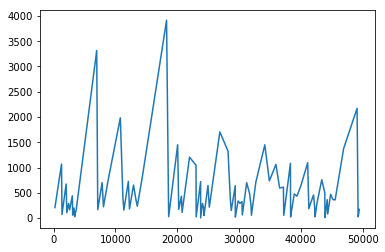

In [22]:
plt.plot(time, game_length_over_t)

In [13]:
game_length = 0
play_game_length_over_t = []
play_time = []
with tf.Session() as sess:
    
    if os.path.isfile("./.index"):
        saver.restore(sess, './')
        
        
        for t in range(2000):
            #Reset world if goal is reached  
            if over:            
                finished +=1
                my_world.restart()
                state = my_world.get_frame()


            #Perform actions according to online network and our custom epsilon greedy policy.
            q_values = predictor_out.eval(feed_dict={x: [state]})
            action_idx = np.argmax(q_values)
            #Perform action
            actions[action_idx]()
            #observe world...
            state, reward, over = (my_world.get_frame(),\
                                        my_world.get_reward(),\
                                        my_world.game_over(precision=precision))

           
            #Keep track of game_length over time
            game_length += 1

            if over:
                play_game_length_over_t.append(game_length)
                play_time.append(t)
                game_length = 0

INFO:tensorflow:Restoring parameters from ./


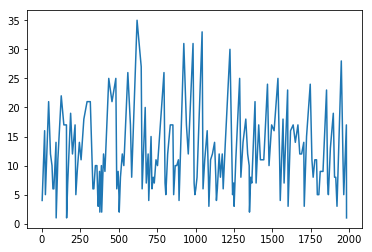

In [14]:
plt.plot(play_time,play_game_length_over_t)